# Project 2 - Ames Housing Data - Final Notebook.

## Importing all the data and necessary libraries/ modules.

#### We will be using standard libraries like numpy, matplotlib/ seaborn, and sklearn as well as more robust modules like Ridge, Lasso and ElasticNet regression and cross validation libraries.

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Importing the data - our training set will be called 'ames_data'. I also want to get rid of all the spacing in my column names so I am going to perform a simple lambda transformation.



In [69]:
ames_data = pd.read_csv("train.csv")

ames_data.columns = ames_data.columns.map(lambda x: str(x.replace(' ', '_')))

##### First thing, first before we start playing with the data, let's make sure its imported properly.

In [70]:
ames_data.head(n=10)

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,109,533352170,60,RL,nan,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.000,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.000,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000
3,318,916386060,60,RL,73.000,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,174000
4,255,906425045,50,RL,82.000,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,138500
5,138,535126040,20,RL,137.000,16492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
6,2827,908186070,180,RM,35.000,3675,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,145,535154050,20,RL,nan,12160,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml,142000
8,1942,535353130,20,RL,nan,15783,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,400,6,2007,WD,Normal,112500
9,1956,535426130,60,RL,70.000,11606,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,9,2007,WD,Family,135000


## Introductory Look at the data. Correlations and Descriptive Statistics. 

##### Okay so now that our data has been imported it looks like we have a fair amount of null or NAN values, we need to check these out before getting into any analysis or looking for correlations.

Our target variable is 'SalePrice' lets look at how it's distributed and some simple descripive statistics on it.

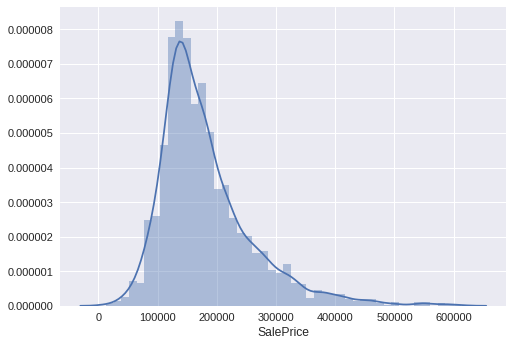

In [71]:
sns.distplot(ames_data['SalePrice']);

So it appears that the data is skewed a little to the right, we might need to transform the data with a log or CoxBox transformation to create a more normal distribution. 

Checking the descriptive stats on the target variable. 

In [72]:
ames_data['SalePrice'].describe()

count     2051.000
mean    181469.702
std      79258.659
min      12789.000
25%     129825.000
50%     162500.000
75%     214000.000
max     611657.000
Name: SalePrice, dtype: float64

In [73]:
print("Skewness: %f" % ames_data['SalePrice'].skew())
print("Kurtosis: %f" % ames_data['SalePrice'].kurt())

Skewness: 1.557551
Kurtosis: 3.579003


From the above we see that the skew is postive which means that the data is skewed to the right; there is a long tail to the right that is caused by extremely large values which pull the mean upward so that it is greater than the median.

The kurtosis of ~3.57 tells us its central peak is higher and sharper, and its tails are longer and fatter than a normally distrubuted population. 

##### So now that we know what our target variable looks like, lets see how some of the more common indicators of housing prices are correlated with the target variable.

First variable that comes to mind is Gr_Liv_Area - or above grade living area (in square feet). Intuitively this variable is going to be even more important for houses without a basement.  

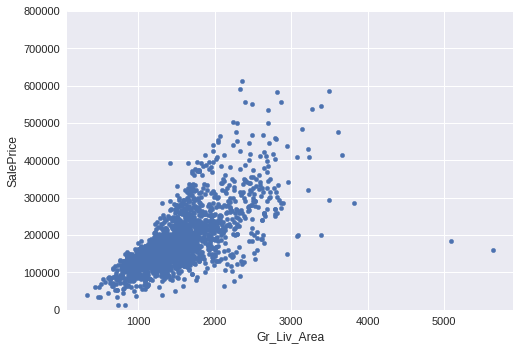

In [74]:
var = 'Gr_Liv_Area'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Giddy up. Aside from the two massive properties that sold for dirt cheap it looks like there is a strong relationship between Above Grade Living Area and Sale Price. 

More to come on the two oddballs.


So now that we know there is a relationship with above ground living space, lets check out the square footage below deck. 

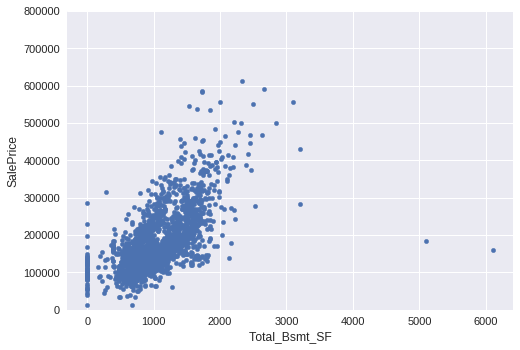

In [75]:
var = 'Total_Bsmt_SF'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Once again we see the two outliers but none the less can see a strong correlation between Basement Square Footage and Sale Price. 

##### Since we have seen how some of the numerical variables are interacting lets look at some categorical ones.

Starting out with Overall Quality.

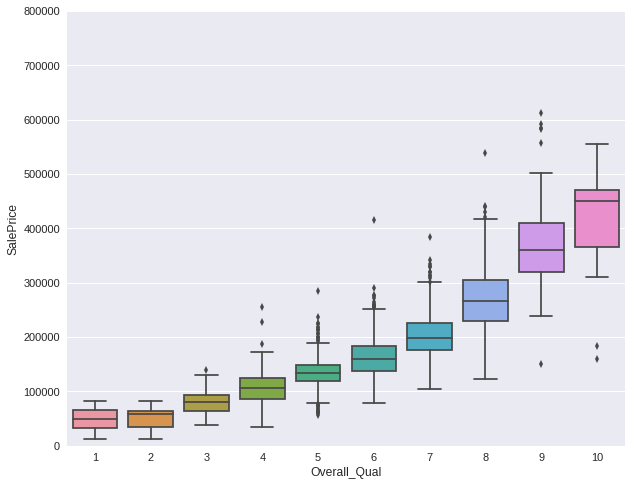

In [76]:
var = 'Overall_Qual'
data = pd.concat([ames_data['SalePrice'], ames_data[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Okay this is what we would expect, a higher Overall Quality is associated with a higher Sale Price. 

Let's see how Year Sold stack up with Sales Price.

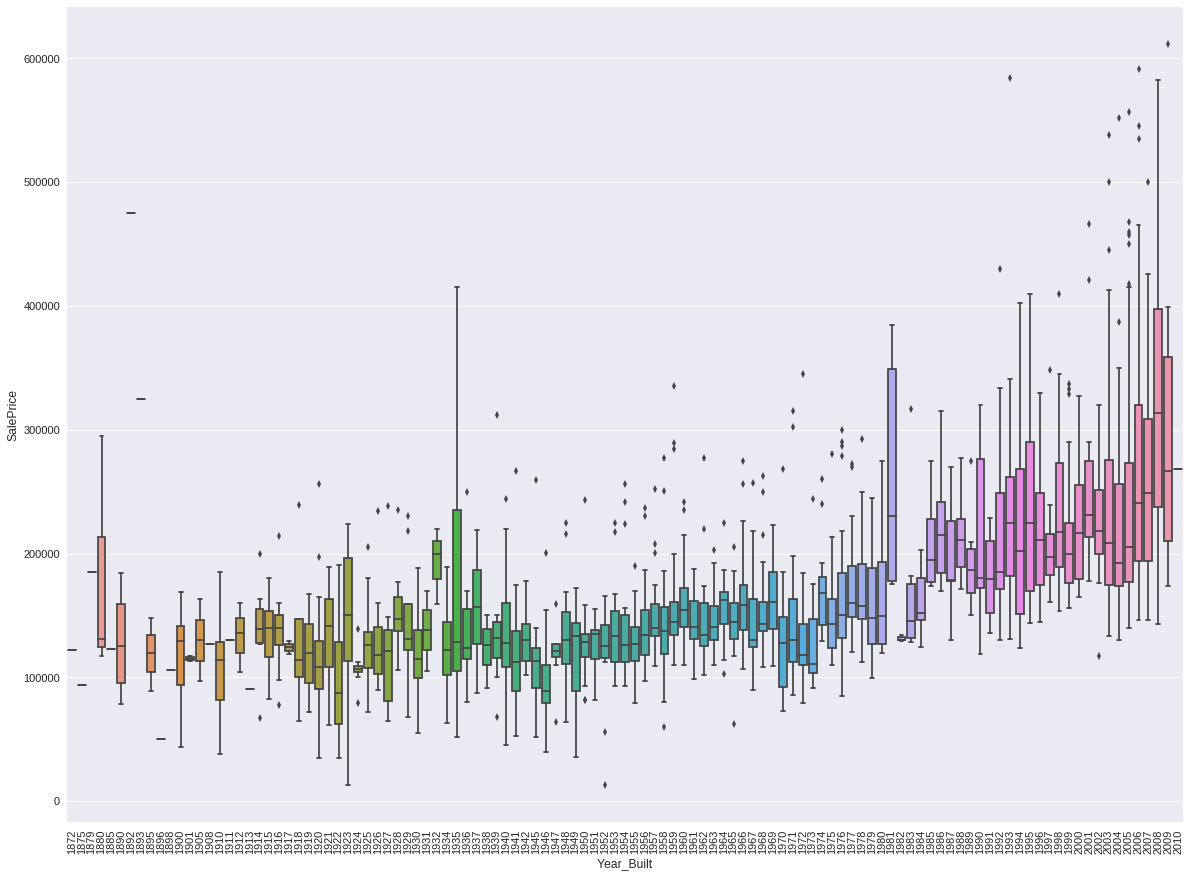

In [77]:
fig, ax = plt.subplots(figsize=(20,15))

year_built_box = sns.boxplot(x=ames_data['Year_Built'], y=ames_data['SalePrice'])
plt.xticks(rotation=90);

Although it's not a strong tendency, I'd say that Sale Price is more correlated to spending more money on new stuff than old fixer uppers.

Note: we don't know if Sale Price is in constant prices. Constant prices try to remove the effect of inflation. If Sale Price is not in constant prices, it should be, so than prices are comparable over time.

##### Summary

We see that two of our numerical variables are positively correlated with Sale Price and at least one of our categorical variables are associated with Sale Price. Our positive relationship between the variables means that as the variables increase we should see an increase in Sale Price. 

##### Correlation Heatmap


Since we only have a feeling for a handful of variables lets check out the rest of the variables in a Seaborn Heatmap.

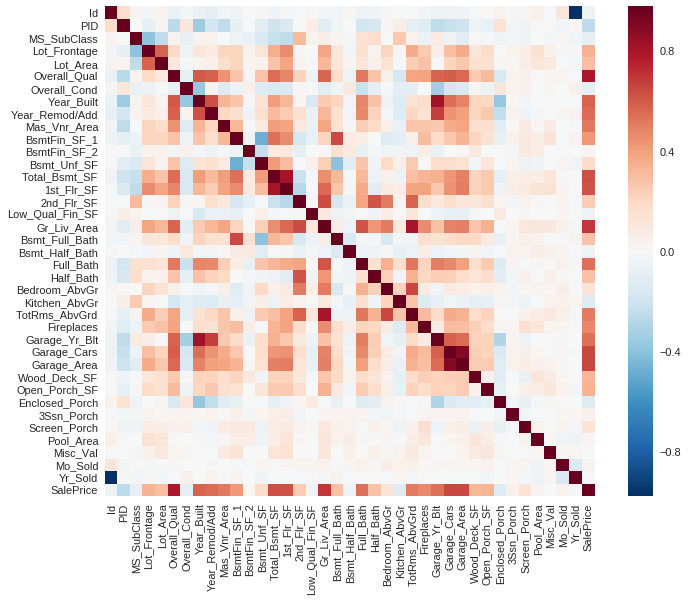

In [78]:
corrmat = ames_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Lets drill down to Sale Price and some of the correlations within the dataset. 
Enhance!

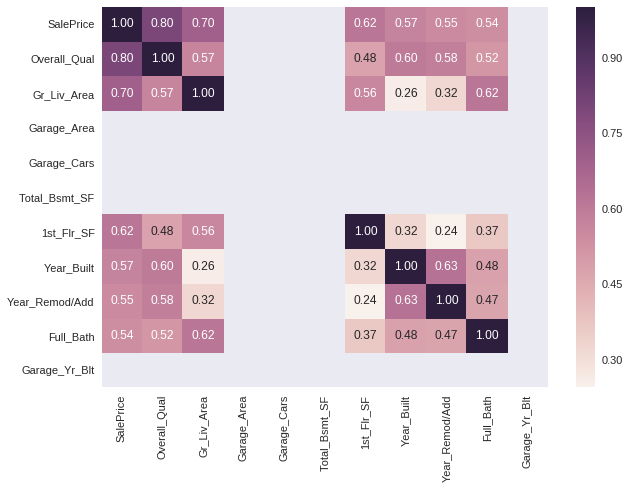

In [79]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
columns = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(ames_data[columns].values.T)
f, ax = plt.subplots(figsize=(10, 7))
sns.set(font_scale=1.1)
heatmap = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=columns.values, xticklabels=columns.values)
plt.show();

Thoughts on the heatmap:

-Garage_Area and Garage_Cars have nice correlation with Sale Price but we probably only need to include one since there is a very strong correlation between the two.

-Similar case for Bsmt_SF and 1st_Flr_SF, which makes sense, since 1st floors are on top of basements...

-Overall_Qual, Gr_Liv_Area and Total_Bsmt_SF are strongly correlated with SalePrice. Confirms earlier assumption!

## Missing Data. Inspection and Imputation.

##### From a high level lets look at some of the missing data and see what it tells us.

In [80]:
total = ames_data.isnull().sum().sort_values(ascending=False)
percent = (ames_data.isnull().sum()/ames_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Pool_QC,2042,0.996
Misc_Feature,1986,0.968
Alley,1911,0.932
Fence,1651,0.805
Fireplace_Qu,1000,0.488
Lot_Frontage,330,0.161
Garage_Cond,114,0.056
Garage_Finish,114,0.056
Garage_Yr_Blt,114,0.056
Garage_Qual,114,0.056


So it looks like there are a few columns where more than 20% of the data is missing, I think it is safe to get rid of these columns. 

In [81]:
ames_data = ames_data.drop(["Alley",'Fireplace_Qu','Pool_QC','Fence', 'Misc_Feature'], axis = 1)

Running again to see the new percentages and if we are comfortable with it.

In [82]:
total = ames_data.isnull().sum().sort_values(ascending=False)
percent = (ames_data.isnull().sum()/ames_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Lot_Frontage,330,0.161
Garage_Finish,114,0.056
Garage_Yr_Blt,114,0.056
Garage_Qual,114,0.056
Garage_Cond,114,0.056
Garage_Type,113,0.055
Bsmt_Exposure,58,0.028
BsmtFin_Type_2,56,0.027
Bsmt_Qual,55,0.027
BsmtFin_Type_1,55,0.027


Okay, this looks good, comfortable with the missing values. From a homebuyer in Ames, IA I dont think that these features would have a significant impact on the eventual Sale Price.


One interesting thing in the above table are 5 Garage categories which are missing 5% of their respective data points, these are probably houses without a garage. More to come on this later.

##### Outliers and odd data points.

We saw earlier that there are a couple odd ducks out there, lets take a look at them and see if we can justify removing them from our analysis. 

Lets reference our graph again.


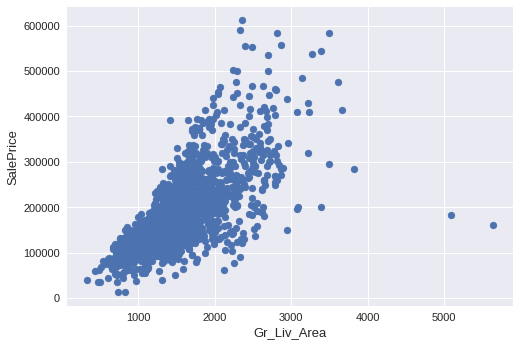

In [83]:
fig, ax = plt.subplots()
ax.scatter(ames_data['Gr_Liv_Area'], ames_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr_Liv_Area', fontsize=13)
plt.show()

The two points on the far right of the graph are what we are interested in. They are >4,500 square feet and sold for less than $200,000. I think its safe to say that these two points are not indicitive of the rest of the population.

In [84]:
ames_data = ames_data.drop(ames_data[(ames_data['Gr_Liv_Area']>4000) & (ames_data['SalePrice']<300000)].index)

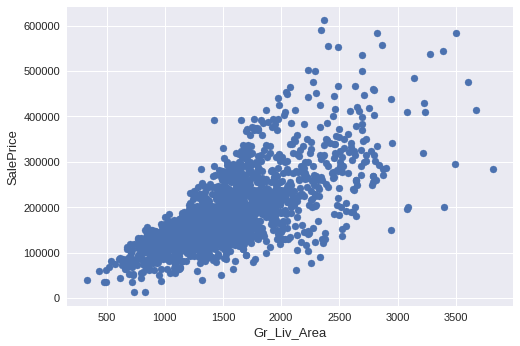

In [85]:
fig, ax = plt.subplots()
ax.scatter(ames_data['Gr_Liv_Area'], ames_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr_Liv_Area', fontsize=13)
plt.show()

Much better.

##### Lets now clean up the remaining data before we move on to our regression and classification challenges.

This is a function I created to clean up all the string data and replace it with numerical data. 


In [86]:
def string_cleaning(df):
    return df.replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'Av': 3, 'Mn': 2, 'No': 1,\
                            'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 4, 'LwQ': 2, 'Unf': 1, 'Typ': 5, 'Min1': 4,\
                            'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sal': 0,'Fin': 3, 'RFn': 2, 'Unf': 1,\
                            'AllPub': 1, 'Pave': 1, 'Grvl': 0, 'AllPub': 4, 'NoSewr':3, 'NoSeWa':2, "ELO":1 }, inplace = True)
string_cleaning(ames_data)


Remember those Garages from earlier? Lets take minute to clean those up, in this case we will replace all the NAs with a 0 for 'no garage'.

In [87]:
def garage_cleaner(df):
    for col in ['Garage_Yr_Blt', 'Garage_Area', 'Garage_Cars']: 
        df[col] = df[col].fillna(0)
        
garage_cleaner(ames_data)

Here is a function that I created to clean up some of the empty basement data. If there was an 'na' which meant no basement I filled with a 0.


In [88]:
def no_basement(df):
    for col in ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF','Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath']:
        df[col] = df[col].fillna((0))
        
no_basement(ames_data)

Looking now to transform and manipulate some of the data. Here I wanted to take all the blank lot frontage data and fill it by the grouped by neighborhood median lot frontage. I figured that lots in the same neighborhood would have similar sizes. 


In [89]:
ames_data["Lot_Frontage"] = ames_data.groupby("Neighborhood")["Lot_Frontage"].transform(lambda x: x.fillna(x.median()))

Transforming the Sale Conition variable, all sales that are not Abnormal are coded to 0 where the Abnormal sales are coded to a 1.

In [90]:
ames_data.Sale_Condition.replace({'Normal': 0, 'Partial': 0, 'Abnorml': 1, 'Family': 0, 'Alloca': 0, 'AdjLand': 0}, inplace=True)

###### Lets now check how the dataframe is looking with a quick check of ames_data.head(10)

In [91]:
ames_data.head(10)

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,...,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,109,533352170,60,RL,70.000,13517,1,IR1,Lvl,4,...,0,0,0,0,0,3,2010,WD,0,130500
1,544,531379050,60,RL,43.000,11492,1,IR1,Lvl,4,...,0,0,0,0,0,4,2009,WD,0,220000
2,153,535304180,20,RL,68.000,7922,1,Reg,Lvl,4,...,0,0,0,0,0,1,2010,WD,1,109000
3,318,916386060,60,RL,73.000,9802,1,Reg,Lvl,4,...,0,0,0,0,0,4,2010,WD,0,174000
4,255,906425045,50,RL,82.000,14235,1,IR1,Lvl,4,...,0,0,0,0,0,3,2010,WD,0,138500
5,138,535126040,20,RL,137.000,16492,1,IR1,Lvl,4,...,0,0,0,0,0,6,2010,WD,0,190000
6,2827,908186070,180,RM,35.000,3675,1,Reg,Lvl,4,...,0,0,0,0,0,6,2006,New,0,140000
7,145,535154050,20,RL,72.000,12160,1,IR1,Lvl,4,...,0,0,0,0,0,5,2010,COD,1,142000
8,1942,535353130,20,RL,60.000,15783,1,Reg,Lvl,4,...,0,0,0,0,400,6,2007,WD,0,112500
9,1956,535426130,60,RL,70.000,11606,1,IR1,HLS,4,...,0,0,0,0,0,9,2007,WD,0,135000


###### Now that the data is looking good, I want to add some columns and new features. 

This first new column calculates all the square footage a property might have, something that I think will be very important to Sale Price.

In [92]:
ames_data["Total_SF"] = ames_data['Gr_Liv_Area'] + ames_data["Total_Bsmt_SF"] + ames_data["Garage_Area"] + ames_data['Wood_Deck_SF']\
    + ames_data["Open_Porch_SF"] + ames_data['Enclosed_Porch'] + ames_data['3Ssn_Porch'] + ames_data['Screen_Porch']\
    + ames_data['Pool_Area']



This second column creates the total number of bathrooms in a house, once again, something that I think is important to overall Sale Price. 

In [93]:
ames_data["Total_Bathrooms"] = ames_data['Bsmt_Full_Bath'] + ames_data['Bsmt_Half_Bath'] + ames_data['Full_Bath'] + ames_data['Half_Bath']

As a final check I want to see how many missing values I have left; I will create a missing_data variable for this. 


In [94]:
missing_data = ames_data.isnull().sum()

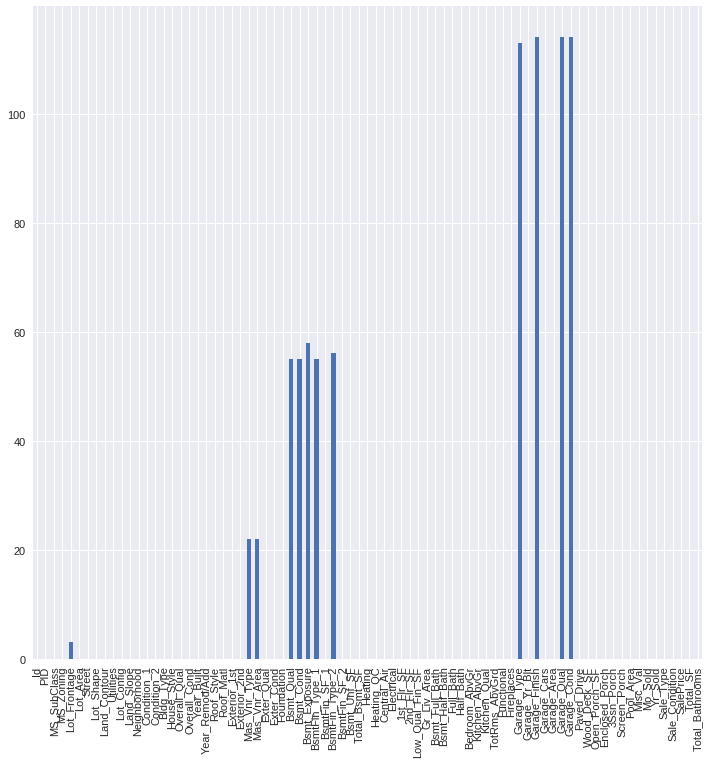

In [95]:
fig, ax = plt.subplots(figsize=(12,12))
missing_data.plot(kind = 'bar')

In [96]:
ames_data = ames_data.dropna(axis = 0, how = 'any')


Dropped the remainder of the missing data, I believe there will be enough data left to give us robust results. 

## Sale Price Regression


### Our first challenge is to use regression models to accurately predict the Sale Price; for this I will be using a combination of Linear, Ridge, Lasso and ElasticNet Regression techniques.  Our overall goal is to get a score close to 1.0.


##### I ran close to 30 different models to come up with my optimal score, I only be showing my first couple of regressions to establish my work flow and then a few others that showcase how I fine tuned my models.

### Here is the first model I ran, used standard Linear Regression and no Pipelines.


In [97]:
y = ames_data['SalePrice']

features = ['Overall_Qual', 'Garage_Area','1st_Flr_SF', 'Total_Bsmt_SF', 'Year_Built']

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

My target variable is Sale Price and I am trying to predict Sale Price off of the 5 attributes that I assigned to the features variable. 

My work flow started by defining my variables (X,y), splitting the data into training and testing data; so I could check the accuracy of my model. After splitting my data I ran it through the StandardScaler I did this because the model might perform poorly if the individual features do not look more-or-less normally distributed. 

In [98]:
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=10)
print(lr_scores)
print(np.mean(lr_scores))

[ 0.81943736  0.79288726  0.74155769  0.72768463  0.75595231  0.78882222
  0.74342572  0.84015584  0.67475761  0.79244153]
0.767712215997


Here we can see that the average Linear Regression (lr) score is .7677 which implies that using the features above we can accurately guess the Sale Price 76% of the time.


##### So now that we have a baseline with the Linear Regression models lets look at some more robust ones like Ridge, Lasso and ElasticNet. 

###### Ridge

In [99]:
ridge_alphas = np.logspace(0,5,200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge = optimal_ridge.fit(X_train_scaled,y_train)

print(optimal_ridge.alpha_)


optimal_ridge_train_score = optimal_ridge.score(X_train_scaled, y_train)
optimal_ridge_test_score = optimal_ridge.score(X_test_scaled, y_test)

print(optimal_ridge_train_score, optimal_ridge_test_score)

24.0940356024
0.774663755244 0.735365686514


###### Lasso

In [100]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso = optimal_lasso.fit(X_train_scaled, y_train)

print(optimal_lasso.alpha_)

optimal_lasso_train_score = optimal_lasso.score(X_train_scaled, y_train)
optimal_lasso_test_score = optimal_lasso.score(X_test_scaled, y_test)

print(optimal_lasso_train_score, optimal_lasso_test_score)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.3731833386
0.774760812012 0.73595565471


...............................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


###### ElasticNet

In [101]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1)

optimal_enet = optimal_enet.fit(X_train_scaled, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

optimal_enet_train_score = optimal_enet.score(X_train_scaled, y_train)
optimal_enet_test_score = optimal_enet.score(X_test_scaled, y_test)

print(optimal_enet_train_score, optimal_enet_test_score)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.3731833386
1.0
0.774760812012 0.73595565471


...............................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.0s finished


In [102]:
print('Optimal Ridge Score: ', optimal_ridge_train_score)
print('Optimal Lasso Score: ', optimal_lasso_train_score)
print('Optimal Enet Score: ' ,optimal_enet_train_score)

Optimal Ridge Score:  0.774663755244
Optimal Lasso Score:  0.774760812012
Optimal Enet Score:  0.774760812012


Recall from above our Linear Regression score was .7677 but the Lasso/Ridge Regression did a little better. For this model it would be best to use the Lasso/Enet.

### Second Pass at it, used a few different variables. In this example I used GridSearch which help automate some of the Ridge, Lasso and ElasticNet parameters.


In [103]:
y = ames_data["SalePrice"]

features = ['Overall_Qual', 'Exter_Qual','Gr_Liv_Area','Kitchen_Qual','Bsmt_Qual',\
    'Garage_Cars','Garage_Area','1st_Flr_SF','Total_Bsmt_SF','Year_Built','Full_Bath']

X = ames_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()

In [104]:
params = {
    
    'alpha': np.arange(.6, 1.0, .00001),
    'max_iter': [2000]
}

gs = GridSearchCV(lasso, params, cv=10)
gs_lasso = gs.fit(X_train_scaled, y_train) 
print(gs_lasso.best_params_)
print(gs_lasso.best_score_)

{'alpha': 0.99998999999817961, 'max_iter': 2000}
0.842435926247


In [105]:
params = {
    
    'alpha': np.logspace(0,5,200),
    'max_iter': [2000]
}

gs = GridSearchCV(ridge, params, cv=10)
gs_ridge = gs.fit(X_train_scaled, y_train) 
print(gs_ridge.best_params_)
print(gs_ridge.best_score_)

{'alpha': 27.049597304631355, 'max_iter': 2000}
0.842693330838


In [106]:
params = {
    
    'l1_ratio': np.linspace(0.01, 1.0, 25),
    'max_iter': [2000]
}

gs = GridSearchCV(enet, params, cv=10)
gs_enet = gs.fit(X_train_scaled, y_train) 
print(gs_enet.best_params_)
print(gs_enet.best_score_)

{'l1_ratio': 0.9587500000000001, 'max_iter': 2000}
0.84255626163


In [107]:
print('Optimal Lasso Score: ', gs_lasso.best_score_)
print('Optimal Ridge Score:', gs_ridge.best_score_)
print('Optimal Enet Score:', gs_enet.best_score_)

Optimal Lasso Score:  0.842435926247
Optimal Ridge Score: 0.842693330838
Optimal Enet Score: 0.84255626163


###### We can see that Lasso has been performing fairly well for our models, this is because Lasso Regression supresses variables it deems unimportant and sets them to 0. This means that the variables that have a higher correlateion with Sale Price are more pronounced. 

### Third  attempt, in this model I introduced Pipelines which allowed me to really streamline the regression process and will be featured in all models after this. 

In [108]:
y = ames_data["SalePrice"]

features = ['Total_SF', 'Overall_Qual', 'Exter_Qual', 'Total_Bathrooms', 'Kitchen_Qual', 'TotRms_AbvGrd', "Year_Remod/Add"]


X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [109]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

lasso = Lasso()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('lasso', lasso)
])

params = {
    
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'lasso__max_iter' : [4000,5000],
    'lasso__alpha': np.arange(.99, 1., .000025)
    
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_lasso = gs.fit(X_train, y_train)
print(gs_lasso.best_score_)
gs_lasso.best_params_

0.879764205613


{'imputer__strategy': 'mean',
 'lasso__alpha': 1.0000000000000211,
 'lasso__max_iter': 5000}

In [110]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

ridge = Ridge()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('ridge', ridge)
])

params = {
    
    'ridge__max_iter': [500],
    'ridge__alpha' : np.arange(1.79, 1.9,.00001),
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_ridge = gs.fit(X_train, y_train)
print(gs_ridge.best_score_)
gs_ridge.best_params_

0.881326998274


{'imputer__strategy': 'mean',
 'ridge__alpha': 1.8999900000007206,
 'ridge__max_iter': 500}

In [111]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

enet = ElasticNet()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('enet', enet)
])

params = {}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_enet = gs.fit(X_train, y_train)
print(gs_enet.best_score_)
gs_enet.best_params_

0.858918516091


{}

In [112]:
print('Optimal Lasso Score: ', gs_lasso.best_score_)
print('Optimal Ridge Score:', gs_ridge.best_score_)
print('Optimal Enet Score:', gs_enet.best_score_)

Optimal Lasso Score:  0.879764205613
Optimal Ridge Score: 0.881326998274
Optimal Enet Score: 0.858918516091


As we train our model more and more the better it seems to get.

In [ ]:
y = ames_data['SalePrice']

features = ['Total_SF','Total_Bathrooms','Overall_Qual', 'Exter_Qual', 'Kitchen_Qual', 'Garage_Cars', 'Bsmt_Qual',]

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

lasso = Lasso()

pipe = Pipeline([
    

    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('lasso', lasso)
]) 

params = {
    
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'lasso__alpha': np.arange(.4, .5, .00005),
    'lasso__max_iter': [1500]
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
lasso_gs = gs.fit(X_train, y_train)
print(lasso_gs.best_score_)
lasso_gs.best_params_

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

ridge = Ridge()

pipe = Pipeline([
    
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('ridge', ridge)
]) 

params = {
    
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'ridge__alpha': np.logspace(1,100,1),
    'ridge__max_iter': [1500,2000]
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
ridge_gs = gs.fit(X_train, y_train)
print(ridge_gs.best_score_)
ridge_gs.best_params_

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

enet = ElasticNet()

pipe = Pipeline([
    
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('enet', enet)
]) 

params = {
    
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
enet_gs = gs.fit(X_train, y_train)
print(enet_gs.best_score_)
enet_gs.best_params_

In [ ]:
print('Optimal Lasso Score: ', gs_lasso.best_score_)
print('Optimal Ridge Score:', gs_ridge.best_score_)
print('Optimal Enet Score:', gs_enet.best_score_)

Our model is slowly becoming better, by tuning some of the features in the 'params' dictionary we can adjust and improve upon our Lasso, Ridge and Enet scores.

### Fourth  attempt, I will continue to pair down on variables and fine tune the individual parameters. 

In [ ]:
y = ames_data["SalePrice"]

features = ['Total_SF', 'Overall_Qual', 'Exter_Qual', 'Total_Bathrooms', 'Kitchen_Qual', 'TotRms_AbvGrd', "Year_Remod/Add"]

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

lasso = Lasso()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('lasso', lasso)
])

params = {
    
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'lasso__max_iter' : [3000,4000],
    'lasso__alpha': np.arange(.99, 1., .0001)
    
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_lasso = gs.fit(X_train, y_train)
print(gs_lasso.best_score_)
gs_lasso.best_params_

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

ridge = Ridge()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('ridge', ridge)
])

params = {
    
    'ridge__max_iter': [500],
    'ridge__alpha' : np.arange(1.79, 1.9,.00001),
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_ridge = gs.fit(X_train, y_train)
print(gs_ridge.best_score_)
gs_ridge.best_params_

In [ ]:
poly = PolynomialFeatures(include_bias=False)

imputer = Imputer()

ss = StandardScaler()

enet = ElasticNet()

pipe = Pipeline([
    
    ('imputer', imputer),
    ('poly', poly),
    ('ss', ss),
    ('enet', enet)
])

params = {}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs_enet = gs.fit(X_train, y_train)
print(gs_enet.best_score_)
gs_enet.best_params_

In [ ]:
print('Optimal Lasso Score: ', gs_lasso.best_score_)
print('Optimal Ridge Score:', gs_ridge.best_score_)
print('Optimal Enet Score:', gs_enet.best_score_)

## Abnormal Sale Classification

### Our goal is to predict whether a sale was made in an abnormal fashion or not, for this we will be using the KNearestNeighbors module.


#### Lets explore this data a bit by exploring a heatmap like we did with Sale Price. 

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(ames_data.corr()[['Sale_Condition']], annot=True)

#### Yikes, it doesn't look like there is much correlation here, we might have to use our intution to get a better idea of what constitutes an abnormal sale.

In [ ]:
y = ames_data['Sale_Condition']

features = ['Low_Qual_Fin_SF', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'Yr_Sold', 'Low_Qual_Fin_SF']

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
imputer = Imputer()

ss = StandardScaler()

knn = KNeighborsClassifier()

pipe = Pipeline([
    
  
    ('imputer', imputer),
    ('ss', ss),
    ('knn', knn)
])

params = {
    
    'knn__n_neighbors': [5,10,15,20,25],
    'knn__p': [1,2],
    'knn__algorithm': ['auto']
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

In [ ]:
y = ames_data['Sale_Condition']

features = ['Mo_Sold', 'Yr_Sold', 'Total_SF', 'SalePrice']

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
imputer = Imputer()

ss = StandardScaler()

knn = KNeighborsClassifier()

pipe = Pipeline([
    
  
    ('imputer', imputer),
    ('ss', ss),
    ('knn', knn)
])

params = {
    
    'knn__n_neighbors': [5,10,15,20,25],
    'knn__p': [1,2],
    'knn__algorithm': ['auto']
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

In [ ]:
y = ames_data['Sale_Condition']

features = ['SalePrice', 'Year_Built', 'Mo_Sold', 'Street', 'Enclosed_Porch']

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
imputer = Imputer()

ss = StandardScaler()

knn = KNeighborsClassifier()

pipe = Pipeline([
    
  
    ('imputer', imputer),
    ('ss', ss),
    ('knn', knn)
])

params = {
    
    'knn__n_neighbors': [5,10,15,20,25],
    'knn__p': [1,2],
    'knn__algorithm': ['auto']
}

gs = GridSearchCV(pipe, param_grid=params, cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

#### All of these models returned roughly the same result. This was a harded model to predict since there weren't as many correlations to Sale Condition relative to Sale Price.

## Conclusion 


#### While I am satisfied with the quality of my models I feel like there is a lot more to be done. Since Sale Price is a skewed variable I would like to know how to work with Box Cox, Logarithmic and XGB Boost tools. 

#### I feel confident with the scores that I was able ot produce and would like to continue feature engineering and learning new methods to make my findings more robust.